In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
# export
import os
import torch as T
import numpy as np
import math
import pandas as pd
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
%matplotlib inline

In [4]:
# export
class imagenetStats:
    def __init__(self, UseInception=True):
        self.UseInception=UseInception
        self.IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
        self.IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
        self.IMAGENET_INCEPTION_MEAN = (0.5, 0.5, 0.5)
        self.IMAGENET_INCEPTION_STD = (0.5, 0.5, 0.5)
    def getMean(self):
        if self.UseInception: return self.IMAGENET_INCEPTION_MEAN[0]
        
    def getSTD(self):
        if self.UseInception: return self.IMAGENET_INCEPTION_STD[0]
        

In [5]:
transform=imagenetStats(UseInception=True)

transform.getMean(),transform.getSTD()

(0.5, 0.5)

In [6]:
# export
def set_seed(x): 
    #random.seed(x)
    np.random.seed(x)
    T.manual_seed(x)
    T.backends.cudnn.deterministic = True
    T.backends.cudnn.benchmark = False
    if T.cuda.is_available(): 
        T.cuda.manual_seed_all(x)

In [7]:
set_seed(42)

In [8]:
# export 
def byte2np_RGB(response, Save=False, path='data', filename='Test', ClrFirst=True):
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8)
    # reshape array to 4 channel image array H X W X 4
    if ClrFirst: img_rgb = img1d.reshape(3, response.height, response.width)
    else: img_rgb = img1d.reshape(response.height, response.width, 3)
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, img_rgb)
    return img_rgb

In [9]:
# export 
def byte2np_Depth(response, Save=False, path='data', filename='Test', Normalize=True):
    img1d = np.array(response.image_data_float, dtype=np.float)
    if Normalize:
        img1d = img1d * 3.5 + 30
        img1d[img1d > 255] = 255
        img1d=img1d/255
    depth = np.reshape(img1d, (response.height, response.width))
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, depth)
    return depth

In [10]:
# export
def ChangeColor(img, clr_og, clr_new):
    r1, g1, b1 = clr_og # Original value
    r2, g2, b2 = clr_new # Value that we want to replace it with

    blue, green, red = img[:,:,0], img[:,:,1], img[:,:,2]
    mask = (red == r1) & (green == g1) & (blue == b1)
    img[:,:,:3][mask] = [b2, g2, r2]
    return img

In [11]:
# export
def byte2np_Seg(response, Save=False, path='data', filename=f'Test'):
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8)
    img = img1d.reshape(response.height, response.width, 3)
    # Change sky and road color
    road = [177, 172, 224] # RGB road 
    sky = [128, 219, 130] # RGB Sky 

    img=ChangeColor(img, clr_og=road, clr_new=[255,255,255])
    img=ChangeColor(img, clr_og=sky, clr_new=[0,0,0])
    # convert to greyscale
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, img)
    return img

In [12]:
#print(self.df_gps.df.head())
#img_depth=util.byte2np_Depth(self.responses[0], Save=False, path='data', filename='Front_center_DepthPlanarS')
#img_rgb=util.byte2np_RGB(self.responses[1], Save=True, path='data', filename='Front_center_RGBS')
#img_seg=util.byte2np_Seg(self.responses[2], Save=False, path='data', filename=f'Front_center_Seg_{self.episode}_{int(self.deltaTime*1000)}')
#img_gps=self.df_gps.GPS2image(Save=False, path='data', filename='GPS')

In [13]:
sz=(224,224)

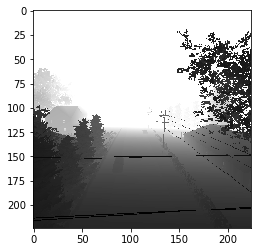

In [14]:
depth=np.load('data/Front_center_DepthPlanarS.npy')
plt.imshow(depth, interpolation='nearest', cmap='gray')
plt.show()

In [15]:
depth=np.load('data/Bottom_center_DepthPlanarS.npy')

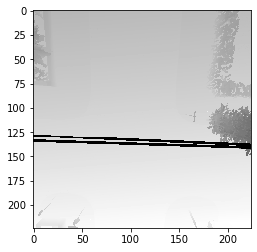

In [16]:
plt.imshow(depth, interpolation='nearest', cmap='gray')
plt.show()

In [17]:
# export
def Distance2Grnd(img, sz, rng=10):
    x,y=sz
    x=int(x/2)
    y=int(y/2)
    return np.mean(img[x-rng:x+rng,y-rng:y+rng])

In [18]:
Distance2Grnd(depth, sz, rng=10)

11.8501953125

In [19]:
def plot_3hgtwdth(img, ClrChng=True):
    img=img.reshape(img.shape[1], img.shape[2],3)
    if ClrChng: img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img, interpolation='nearest')
    plt.show()

In [20]:
#img=np.load('data/Front_center_RGBS.npy')
#plot_3hgtwdth(img)

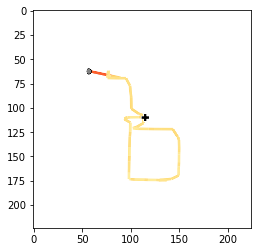

In [21]:
img=np.load('data/GPS.npy')
plot_3hgtwdth(img, ClrChng=False)

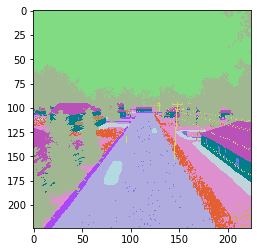

In [22]:
img=np.load('data/Front_center_SegS.npy')
img_=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_, interpolation='nearest')
plt.show()

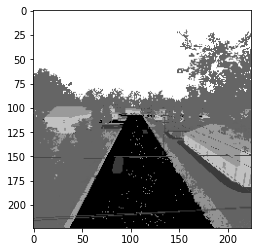

In [23]:
fn = [o.name for o in os.scandir('data') if o.name.find('Seg_')!=-1][4]
img=np.load(f'data/{fn}')
plt.imshow(img, cmap='Greys')
plt.show()

In [24]:
sz=(224,224)

In [25]:
# export
def isRoadBelow(img, sz, rng=10):
    x,y=sz
    x=int(x/2)
    y=int(y/2)
    med=np.median(img[x-rng:x+rng,y-rng:y+rng])
    if med >0.98: return True
    else: return False

In [26]:
isRoadBelow(img, sz, rng=10)

False

In [27]:
df_mesh=pd.read_csv('data/meshes.csv', index_col=0)
#df_mesh['0'].unique()

In [28]:
arr0=np.load('data/FirstArray.npy')
arr1=np.load('data/LastArray.npy')

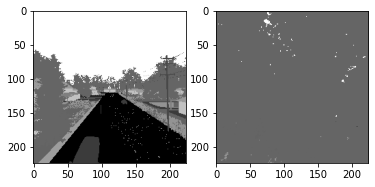

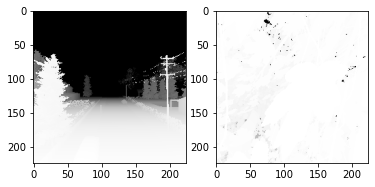

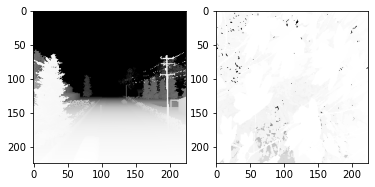

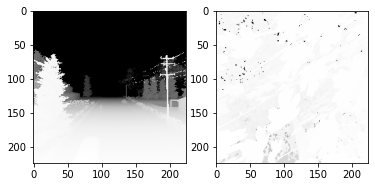

In [29]:
for i in range(arr0.shape[0]):
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(arr0[i], cmap='Greys')
    ax1.imshow(arr1[i], cmap='Greys')
    plt.show()

In [30]:
def Value2Color(val, vmin=0, vmax=1, palette='YlOrRd', zerocolor='#e3e3e3'):    
    """Input value from vmin to vmax returns hex color based on value and palette"""
    import matplotlib as mpl
    import matplotlib.cm as cm
    try:
        if np.isnan(val):
            clr='#e3e3e3' # grey
        elif val==0: clr=zerocolor# green if zero
        else:
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            cmap = cm.get_cmap(palette)   
            m = cm.ScalarMappable(norm=norm, cmap=cmap)
            rgba=m.to_rgba(val)
            clr=mpl.colors.to_hex(rgba)
    except: clr='#e3e3e3' # grey
    return clr

In [31]:
# export
def plotcolorline(x, y, z, cmap='YlOrRd', norm=plt.Normalize(0.0, 1.0), 
              linewidth=3, alpha=1.0):
    #breaks lines into segments and plots segment color as z value in colormap
    import matplotlib.collections as mcoll
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)
    ax = plt.gca()
    ax.add_collection(lc)

    return lc

In [32]:
#function to convert x, y , z vector to gps coordinates needed
# c++
_='''static GeoPoint nedToGeodetic(const Vector3r& v, const HomeGeoPoint& home_geo_point)
        {
            double x_rad = v.x() / EARTH_RADIUS;
            double y_rad = v.y() / EARTH_RADIUS;
            double c = sqrt(x_rad * x_rad + y_rad * y_rad);
            double sin_c = sin(c), cos_c = cos(c);
            double lat_rad, lon_rad;
            if (!Utils::isApproximatelyZero(c)) { //avoids large changes?
                lat_rad = asin(cos_c * home_geo_point.sin_lat + (x_rad * sin_c * home_geo_point.cos_lat) / c);
                lon_rad = (home_geo_point.lon_rad +
                           atan2(y_rad * sin_c, c * home_geo_point.cos_lat * cos_c - x_rad * home_geo_point.sin_lat * sin_c));

                return GeoPoint(Utils::radiansToDegrees(lat_rad), Utils::radiansToDegrees(lon_rad), home_geo_point.home_geo_point.altitude - v.z());
            }
            else
                return GeoPoint(home_geo_point.home_geo_point.latitude, home_geo_point.home_geo_point.longitude, home_geo_point.home_geo_point.altitude - v.z());
        }'''

# this is the print statement from self.client.getGpsData():
_='''<GpsData> {   'gnss': <GnssReport> {   'eph': 0.3000044822692871,
    'epv': 0.40000447630882263,
    'fix_type': 3,
    'geo_point': <GeoPoint> {   'altitude': 132.32289123535156,
    'latitude': 47.6416150728889,
    'longitude': -122.14040436968116},
    'time_utc': 1645971445395087,
    'velocity': <Vector3r> {   'x_val': -0.24463589489459991,
    'y_val': 0.05023214593529701,
    'z_val': -0.6591682434082031}},
    'is_valid': True,
    'time_stamp': 1645971445395087360} <Vector3r> {   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355}
'''

In [208]:
# export
class GPShistory:
    def __init__(self, position, velocity, reward, time_stamp, vehicle_name, image_size, maxspeed):
        self.columns=['x_position', 'y_position', 'z_position',
                     'x_velocity', 'y_velocity', 'z_velocity', 
                     'Reward', 'time_stamp', 'vehicle_name']
        self.sz=image_size
        self.vehicle_name=vehicle_name
        self.maxspeed= maxspeed
        self.df=pd.DataFrame([[position.x_val, position.y_val, position.z_val,
                               velocity.x_val, velocity.y_val, velocity.z_val,
                              reward, time_stamp,vehicle_name]], columns=self.columns)
        
    def appendGPShistory(self, position, velocity, reward, time_stamp, vehicle_name):
        self.df.loc[len(self.df)]= [position.x_val, position.y_val, position.z_val,
                                    velocity.x_val, velocity.y_val, velocity.z_val,
                                    reward, time_stamp,vehicle_name]
        
    def saveGPS2csv(self, filename):
        self.df.to_csv(filename, index=False)
        
    def loadGPScsv(self, filename):
        self.df=pd.read_csv(filename)
        
    def getDataframe(self): return self.df
        
    def GPS2image(self, x_cntr, y_cntr,z_cntr, df_nofly=None):
        df=self.df.copy()
        maxspeed=self.maxspeed
        vehicle_name=self.vehicle_name
        sz=self.sz
        rad=100 # meters                
        # ensures the current vehicle is plotted last
        vehicle_lst=list(df[df['vehicle_name']!=vehicle_name]['vehicle_name'].dropna().unique())+[vehicle_name]
        
        #################################### Plotting #########################################################
        fig, ax = plt.subplots(figsize=(5,5))
        ax=plt.gca(); ax.set_axis_off()
        ax.add_patch(patches.Rectangle((x_cntr-rad,y_cntr-rad+1), width=rad*2-1, height=rad*2-1, ec='k', facecolor='#b3b3b3'))
        ax.add_patch(plt.Circle((x_cntr,y_cntr), rad, ec='k', facecolor='white'))
        plt.xlim(x_cntr-rad,x_cntr+rad); plt.ylim(y_cntr-rad,y_cntr+rad) 
        if df_nofly is not None: # plot the no fly zone
            for idx in df_nofly.index:
                ax.add_patch(plt.Circle((df_nofly.loc[idx,'x'], df_nofly.loc[idx,'y']), df_nofly.loc[idx,'radius'],
                                    hatch='xxx',facecolor='grey'))

        # Plot reward and history of drones
        for v_name in vehicle_lst:
            frame=df[df['vehicle_name']==v_name].copy()   
            # set the most recent position to the center of plot and shows 100 meters in all directions                  
            lc = plotcolorline(frame['x_position'], frame['y_position'],frame['Reward'],
                               cmap='Greys_r', norm=plt.Normalize(-100, 20), linewidth=4,alpha=1.0)           

        # ensure current locations are on top
        for v_name in vehicle_lst:
            frame=df[df['vehicle_name']==v_name].copy()
            if v_name==vehicle_name:
                #honey I'm home
                plt.plot(frame.loc[frame.index[0],'x_position'], frame.loc[frame.index[0],'y_position']
                         , marker='o', color="gray", ms=8, markeredgecolor='black',linestyle='None')
                # Current Location
                plt.plot(x_cntr, y_cntr ,marker='P', color='k', lw=6, ms=16, markeredgecolor='white',linestyle='None',markeredgewidth=2)

            else:
                #Last Location of other drones
                plt.plot(frame.loc[frame.index[-1],'x_position'], frame.loc[frame.index[-1],'y_position']
                         , marker='*', color="white", ms=14, markeredgecolor='k', linestyle='None', markeredgewidth=2)
        
        ax.text(-85,85, f'{int(abs(z_cntr))}',  fontsize = 18)  
        plt.tight_layout()
        fig.canvas.draw()

        # plot to image array
        arr = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        arr = arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
        # this padding only works for 224x224 images
        arr=cv2.resize(arr[9:-11, 9:-11], (sz), interpolation=cv2.INTER_CUBIC)
        # close the figure
        plt.close(fig)
        plt.figure().clear()
        plt.close()
        plt.cla()
        plt.clf()

        return arr
       

In [209]:
# test data
import time

class mimic:
    def __init__(self, dct):
        self.x_val=dct.get('x_val')
        self.y_val=dct.get('y_val')
        self.z_val=dct.get('z_val')
        
        
position=mimic({   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355})
velocity=mimic({   'x_val': 1.724202156066895,
    'y_val': -2.542,
    'z_val': -1.55})

vehicle_name='Drone0'
maxspeed=8.33
sz=(224,224)
time_stamp=time.time_ns()
reward=0


In [210]:
df_gps=GPShistory(position, velocity, reward, time_stamp, vehicle_name, sz, maxspeed)

In [211]:
df_gps.df

,x_position,y_position,z_position,x_velocity,y_velocity,z_velocity,Reward,time_stamp,vehicle_name
0,14.724202,-2.943709,-9.155742,1.724202,-2.542,-1.55,0,1647199979906945632,Drone0


In [212]:
df_gps.loadGPScsv('data/gps_data_Drone0_episode120_DDQN.csv')

In [213]:
df_gps.df

,x_position,y_position,z_position,x_velocity,y_velocity,z_velocity,Reward,time_stamp,vehicle_name
0,15.186294,-3.052529,-6.779292,4.350232,-0.863758,-0.621604,0.000000,1647184619243290661,Drone0
1,18.954014,-3.993683,-8.170862,2.178472,-0.717444,-0.449148,-13.133352,1647184620562483030,Drone0
2,19.004190,-3.680478,-8.205848,1.133567,0.090074,0.060622,-15.670945,1647184624662530420,Drone0
3,19.484133,-3.716915,-8.331051,1.309186,-0.007199,0.077956,-18.392902,1647184628763512171,Drone0
4,18.975420,-2.777489,-8.455786,-0.128017,1.422628,0.087499,-21.122283,1647184632869150281,Drone0


In [214]:
arr=df_gps.GPS2image(10,0.5, 120)

<Figure size 432x288 with 0 Axes>

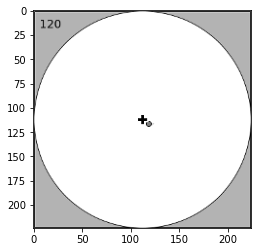

In [215]:
plt.imshow(arr, cmap='gray')
plt.show()

In [41]:
# export
def Penalty4Backtrack(df_gps, vehicle_name, x,y, dist=2, penalty=-3):
    ''' given gps dataframe x,y on most recent index
        calcuates the distance to previous x,y positions
        returns the reward for every position within dist
    '''
    df_tmp=df_gps.copy()
    df_tmp['Distance2Drone']=np.sqrt((x-df_tmp['x_position'])**2+ (y-df_tmp['y_position'])**2)
    return len(df_tmp[(df_tmp['Distance2Drone']<dist)]) * penalty

In [43]:
# export
def HghtReward(z):
    if z>=20:
        return -math.exp(z**0.5)/300
    else: 
        return -1/math.exp(z**0.5-10)/100


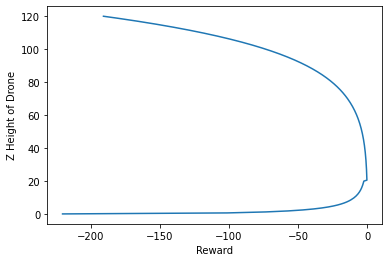

In [44]:
Z=np.linspace(0,120,200)
plt.plot([HghtReward(z) for z in Z], Z)
plt.ylabel('Z Height of Drone')
plt.xlabel('Reward')
plt.show()

In [45]:
# export
def DroneDistanceReward(d):
    if d>=50:
        return  -math.exp(10-(-d+100)**0.5)/100
    else:
        return (-math.exp(-d**0.5+10))/100

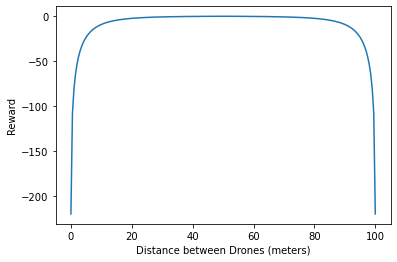

In [46]:
D=np.linspace(0,100,200)
plt.plot(D, [DroneDistanceReward(d) for d in D])
plt.ylabel('Reward')
plt.xlabel('Distance between Drones (meters)')
plt.show()

In [47]:
60/1.5

40.0

In [154]:
# export
def plot_Reward(df_summary, path, filename, show=False):
    fig=plt.figure(figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
    filename = os.path.join(path, f'{filename}.png')
    plt.scatter(df_summary['Episode'], df_summary['Score'], alpha=0.5, label='Episode Score')
    plt.plot(df_summary['Episode'], df_summary['Average Score'], color='orange', label='Running Average')
    plt.ylabel('Reward')
    plt.xlabel('Episodes')
    plt.legend(loc=2)

    plt.ylim(-1000,10)
    plt.grid()
    
    
    plt.savefig(filename)
    if show: plt.show()
    
    plt.close(fig)
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()



In [155]:
pd.set_option('display.max_rows', 500)

In [239]:
df_summary=pd.read_csv('data/Neighborhood_DDQNAgent_2022-03-13.csv')

In [240]:
#df_summary['Average Score']=[np.mean(df_summary.loc[df_summary.index[idx:-50], 'Score']) for idx in df_summary.index]

In [241]:
df_summary

,Episode,Score,Average Score,Best Score,steps,Model Saved,Epsilon,Dropout,Vehicle Name
0,0,-255.970936,-255.970936,-inf,10,True,1.0000,0.001,Drone0
1,1,-388.767700,-322.369318,-255.970936,20,False,1.0000,0.001,Drone0
2,2,-967.977028,-537.571888,-255.970936,30,False,1.0000,0.001,Drone0
3,3,-837.528939,-612.561151,-255.970936,40,False,1.0000,0.001,Drone0
4,4,-343.193780,-558.687677,-255.970936,50,False,1.0000,0.001,Drone0
...,...,...,...,...,...,...,...,...,...
532,532,-51.464867,-65.238064,-62.652868,2206,False,0.7921,0.001,Drone0
533,533,-57.894779,-65.309386,-62.652868,2210,False,0.7917,0.001,Drone0
534,534,-62.831204,-65.335481,-62.652868,2214,False,0.7913,0.001,Drone0
535,535,-58.910081,-65.507802,-62.652868,2218,False,0.7909,0.001,Drone0


In [242]:
#np.mean(df_summary.loc[df_summary.index[:-50], 'Score'])

In [243]:
print(df_summary.tail().T)

                   532      533      534      535      536
Episode            532      533      534      535      536
Score         -51.4649 -57.8948 -62.8312 -58.9101 -56.8451
Average Score -65.2381 -65.3094 -65.3355 -65.5078 -65.5269
Best Score    -62.6529 -62.6529 -62.6529 -62.6529 -62.6529
steps             2206     2210     2214     2218     2222
Model Saved      False    False    False    False    False
Epsilon         0.7921   0.7917   0.7913   0.7909   0.7905
Dropout          0.001    0.001    0.001    0.001    0.001
Vehicle Name    Drone0   Drone0   Drone0   Drone0   Drone0


In [247]:
filename='Neighborhood_DDQNAgent_2022-03-13'
path='plots'

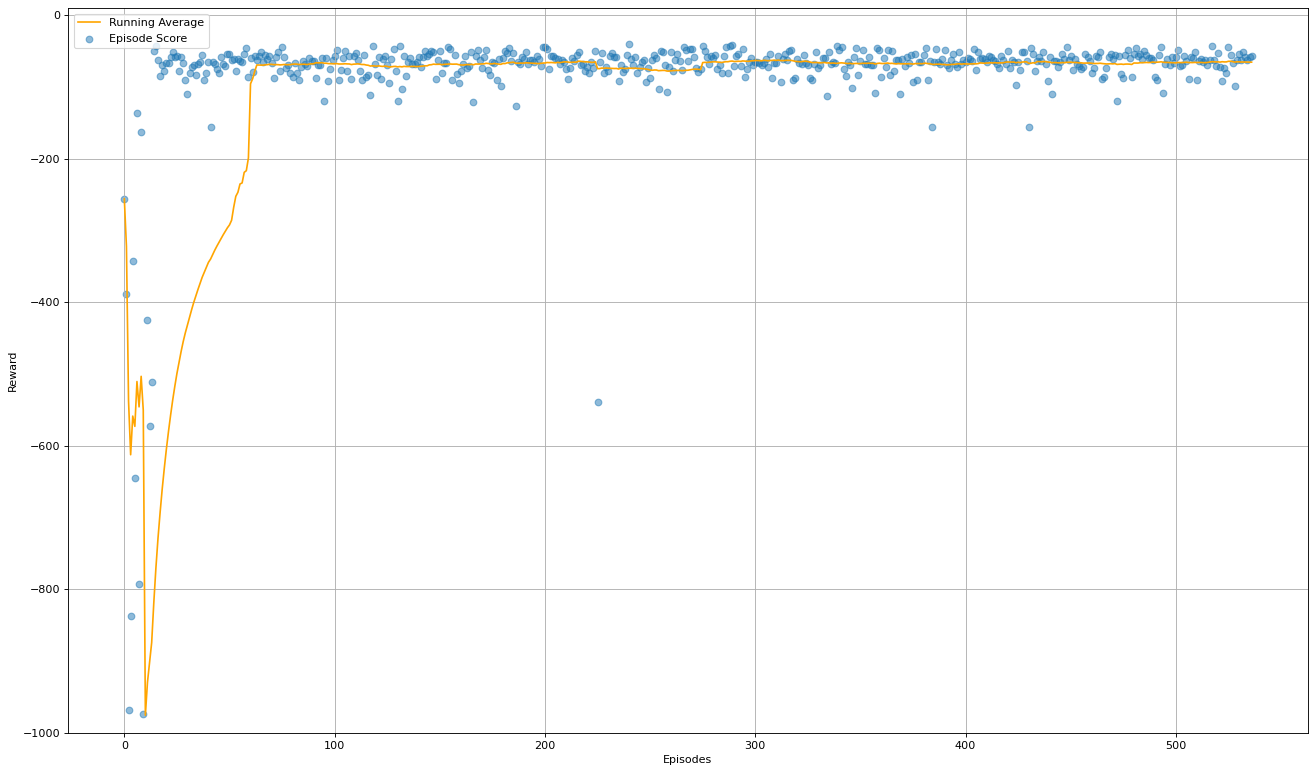

<Figure size 432x288 with 0 Axes>

In [248]:
plot_Reward(df_summary, path, filename, show=True)

In [249]:
df_summary[df_summary['Model Saved']==True]

,Episode,Score,Average Score,Best Score,steps,Model Saved,Epsilon,Dropout,Vehicle Name
0,0,-255.970936,-255.970936,-inf,10,True,1.0000,0.001,Drone0
53,53,-77.258115,-252.478174,-255.970936,290,True,0.9837,0.001,Drone0
54,54,-61.392728,-246.842153,-252.478174,294,True,0.9833,0.001,Drone0
55,55,-64.277312,-235.236091,-246.842153,298,True,0.9829,0.001,Drone0
56,56,-64.934717,-233.821343,-235.236091,302,True,0.9825,0.001,Drone0
57,57,-54.399427,-219.046234,-233.821343,306,True,0.9821,0.001,Drone0
58,58,-46.306704,-216.717656,-219.046234,310,True,0.9817,0.001,Drone0
59,59,-85.737390,-198.943595,-216.717656,314,True,0.9813,0.001,Drone0
60,60,-59.670290,-95.597015,-198.943595,318,True,0.9809,0.001,Drone0
61,61,-79.329289,-88.683352,-95.597015,322,True,0.9805,0.001,Drone0


In [216]:
!python notebook2script.py Utilities.ipynb

Converted Utilities.ipynb to nb_files/nb_Utilities.py


In [217]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Sunday March 13, 2022 at 15:35
